<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Karman filter



# Imports
<hr style = "border:2px solid black" ></hr>

In [6]:
%matplotlib inline

from datetime import datetime
import itertools

import pandas as pd
import pandas_datareader.data as web
from pykalman import KalmanFilter
import pywt

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
idx = pd.IndexSlice

import datetime as dt
import pandas_datareader as pdr

# Import dataset
<hr style = "border:2px solid black" ></hr>

In [95]:
# NLFLX is the netflix stock price
start = dt.datetime(2020, 1, 1)
data = pdr.get_data_yahoo("NFLX", start)

In [96]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,329.980011,324.779999,326.100006,329.809998,4485800,329.809998
2020-01-03,329.859985,325.529999,326.779999,325.899994,3806900,325.899994
2020-01-06,336.359985,321.200012,323.119995,335.829987,5663100,335.829987
2020-01-07,336.700012,330.299988,336.470001,330.750000,4703200,330.750000
2020-01-08,342.700012,331.049988,331.489990,339.260010,7104500,339.260010


In [97]:
df = data["Adj Close"]
df

Date
2020-01-02    329.809998
2020-01-03    325.899994
2020-01-06    335.829987
2020-01-07    330.750000
2020-01-08    339.260010
                 ...    
2022-08-23    224.550003
2022-08-24    229.610001
2022-08-25    233.979996
2022-08-26    223.279999
2022-08-29    225.260101
Name: Adj Close, Length: 670, dtype: float64

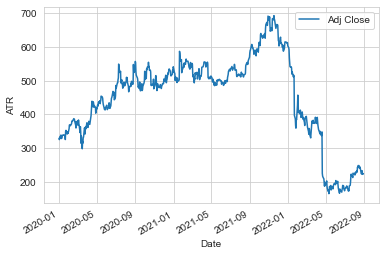

In [99]:
fig, ax = plt.subplots()
df.plot(ax=ax)
ax.set_ylabel("ATR")
data.plot
ax.legend()

# Kalman Filter 
<hr style = "border:2px solid black" ></hr>


- The Kalman filter is a dynamic linear model of sequential data like a time series that adapts to new information as it arrives. Rather than using a fixed-size window like a moving average or a given set of weights like an exponential moving average, it incorporates new data into its estimates of the current value of the time series based on a probabilistic model.

- **Why Use the Word “Filter”?** A noisy time series is like a time series with many rough edges. The Kalman Filter estimates the underlying states. It “filters” out the rough edges to reveal relatively smooth patterns.

- Notice that **smoothing** is different from the smoothing of moving average methods. The moving average methods take the past points, even errors, with differential weights to get a smoothed line. In contrast, the Kalman Filter recognizes some data points as noise. 

- A Kalman filter is called an optimal estimator. Optimal in what sense? The Kalman filter minimizes the mean square error of the estimated parameters. So it is the best-unbiased estimator.

- It is recursive so that `Xt+1` can be calculated only with `Xt`. and does not require the presence of all past data points `X0, X1, …, Xt`. This is an important merit for real-time processing.
    
- The error terms in Equations (1) and (2) are both Gaussian distributions, so the error term in the predicted values also follows the Gaussian distribution.
    
- There is no need to provide labeled target data to “train” a model.
    


# Random walk
<hr style = "border:2px solid black" ></hr>


- Stock price movement is widely modeled as a **random walk**. It means at each point in time the series merely takes a random step away from its last position, with steps that the mean value is zero. 

- This is described in Equation (1) describes: `Xt = At * Xt-1`, where At is the transition matrix and At = 1. This is also called random-walk-without-drift. 

- If the mean step size is a nonzero value α, it is called random-walk-with-drift. It becomes `Xt = At * Xt-1 + α`. 
        


# Connection btw Random walk and Karman filter
<hr style = "border:2px solid black" ></hr>


- It is straightforward to implement the Kalman Filter. Equation (1) only has one term Xt-1. So the transition matrix At only has one value [1.0]. It is 1.0 because of the random walk assumption. We also allow it to have small turbulence of 0.01, meaning the At can sometimes go above 1.0 and sometimes go below 1.0. It is denoted by transition_covariance=0.01. The observation matrix Ct also is 1.0.

- The initial value `X0` can be any value as you'll see how it quickly converges to the true value. The error terms qt and rt are Gaussian-distributed with a mean of 0 and variance of 1.0. So initial_state_covariance=1 and observation_covariance=1.



## Chose filter parameters
<hr style = "border:2px solid black" ></hr>


- `transition_matrices = [1]` = The value for At. It is a random walk so is set to 1.0
- `observation_matrices = [1]` =  The value for Ht.
- `initial_state_mean = 0` = Any initial value. It will converge to the true state value.
- `initial_state_covariance = 1` = Sigma value for the Qt in Equation (1) the Gaussian distribution
- `observation_covariance=1` = Sigma value for the Rt in Equation (2) the Gaussian distribution
- `transition_covariance=.01` = A small turbulence in the random walk parameter 1.0



In [100]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

## Applying the filter to stock
<hr style = "border:2px solid black" ></hr>

In [101]:
# Estimate the hidden state
state_means, _ = kf.filter(df)

In [102]:
Add it to the dataset
data['KF'] = np.array(state_means)

In [103]:
data

,High,Low,Open,Close,Volume,Adj Close,KF
Date,,,,,,,
2020-01-02,329.980011,324.779999,326.100006,329.809998,4485800,329.809998,164.904999
2020-01-03,329.859985,325.529999,326.779999,325.899994,3806900,325.899994,219.280792
2020-01-06,336.359985,321.200012,323.119995,335.829987,5663100,335.829987,249.353015
2020-01-07,336.700012,330.299988,336.470001,330.750000,4703200,330.750000,266.557894
2020-01-08,342.700012,331.049988,331.489990,339.260010,7104500,339.260010,279.734954
...,...,...,...,...,...,...,...
2022-08-23,229.899994,224.300003,226.460007,224.550003,5276900,224.550003,230.895065
2022-08-24,234.100006,223.940002,225.660004,229.610001,5426300,229.610001,230.772823
2022-08-25,234.160004,229.000000,230.240005,233.979996,3766900,233.979996,231.077905


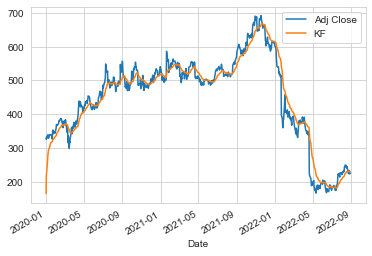

In [106]:
fig, ax = plt.subplots()
df.plot(ax=ax)
data["KF"].plot(ax=ax)
data.plot
ax.legend()


- **The first few estimates are far off from the target “Adj Close”** However, it converges to the target “Adj Close” after the first few observations, as shown in the plot below.
    
- **We do not set up a training dataset to train the model** The Kalman Filter does not work that way. The purpose of training a model is to get the parameters At. The Kalman Filter gets a parameter value for each new time step t.



# References
<hr style = "border:2px solid black" ></hr>


- https://medium.com/dataman-in-ai/kalman-filter-explained-4d65b47916bf
- https://www.quantstart.com/articles/State-Space-Models-and-the-Kalman-Filter/
    
